,class,count
0,Amphiprion_clarkii,4049
1,Chaetodon_lunulatus,2534
2,Chromis_chrysura,3593
3,Dascyllus_reticulatus,12112
4,Plectroglyphidodon_dickii,2683


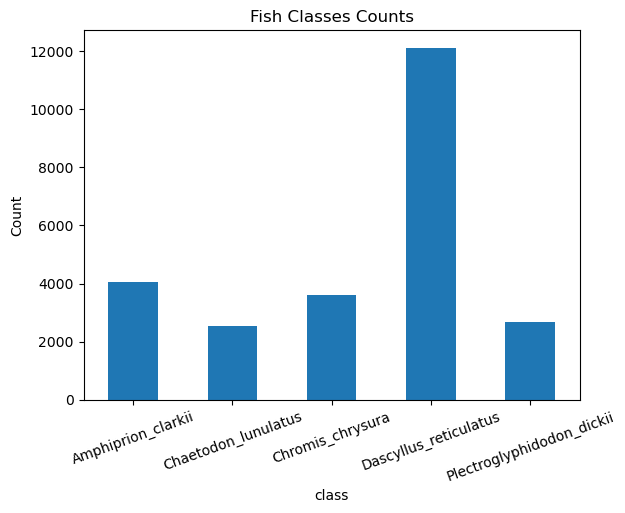

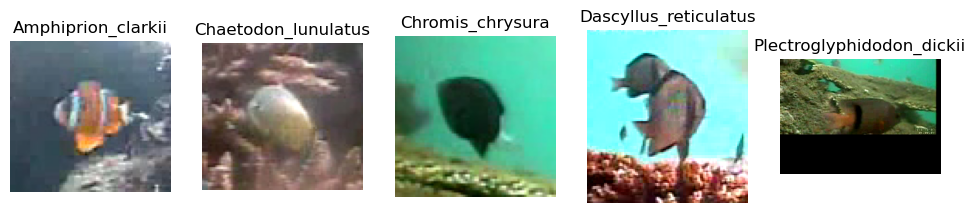

In [1]:
from bd_utils import * #utils.py homemade file
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#Show Data Distribution
p = r"./dataset"
classes = os.listdir(p)

df = pd.DataFrame(columns=["class","count"])

for i in range(0,len(classes)):
    df.loc[i] = [classes[i]] + [len(os.listdir(p+"/"+classes[i]))]
    
display(df)
ax = df.plot.bar(x='class', y='count', rot=20,title = "Fish Classes Counts", ylabel = "Count", legend = 0)

#Show one of each class
plt.figure(figsize=(12, 6))
for i in range(0,len(classes)):
    plt.subplot(1,len(classes),i+1)
    image = mpimg.imread(p+ "/" + classes[i] + "/" + (os.listdir(p+"/"+classes[i])[0]))
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis('off')

In [2]:
############################################################
#Create text file with labels

#imPath_df = pd.DataFrame(columns=["path","class"])
############################################################

#Generate pandas df with paths and labels

# dfInd = 0
# for i in range(0,len(classes)):
#     imList = os.listdir(p+"/"+classes[i])
#     for j in range(0,len(imList)):
#         imPath_df.loc[dfInd] = [p+ "/" + classes[i] + "/" + str(imList[j])] + [i]
#         dfInd += 1

############################################################

# For generating text file
# with open('fish_labels.txt', 'w') as f:
#     for i in range(0,len(classes)):
#         imList = os.listdir(p+"/"+classes[i])
#         for j in range(0,len(imList)):
#             f.write(p+ "/" + classes[i] + "/" + str(imList[j]) + " " + str(i) + "\n")

############################################################

#For reading text file

# imPath_df = pd.read_csv("fish_labels.txt",delim_whitespace=True, header=None, names = ["imP","label"])
# print(len(imPath_df))

# n_df = pd.DataFrame(columns=["imP","label"])

# for i in range(0,5):
#     new_imPath_df = imPath_df[imPath_df["label"]== i].iloc[:100]
#     n_df = pd.concat([n_df,new_imPath_df])

imPath_df, dev_df = create_dataframes("fish_labels.txt") # get main dataset and development version (smaller)
#smaller dataset for testing
display(dev_df)

,imP,label
0,./dataset/Amphiprion_clarkii/fish_000000019599...,0
1,./dataset/Amphiprion_clarkii/fish_000000019599...,0
2,./dataset/Amphiprion_clarkii/fish_000000019599...,0
3,./dataset/Amphiprion_clarkii/fish_000000019599...,0
4,./dataset/Amphiprion_clarkii/fish_000000019599...,0
...,...,...
22383,./dataset/Plectroglyphidodon_dickii/fish_00001...,4
22384,./dataset/Plectroglyphidodon_dickii/fish_00001...,4
22385,./dataset/Plectroglyphidodon_dickii/fish_00001...,4
22386,./dataset/Plectroglyphidodon_dickii/fish_00001...,4


In [3]:
#Only Convolutions
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from keras.layers import Dense, Conv2D, Flatten
from sklearn.utils.multiclass import type_of_target


skf = StratifiedKFold(n_splits=2, shuffle = True, random_state = 123)

X=dev_df.imP
y=dev_df.label
y=y.astype('int') 


gt = [] #ground truth (appended on each fold)
results = [] # validation results (appended on each fold)


#stratified split
for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    
    X_train_im = np.array(path2im(X_train))
    X_test_im = np.array(path2im(X_test))
    
    y_train = process_labels(y_train)
    y_test = process_labels(y_test)
    
    
    train_generator = DataGenerator(X_train_im, y_train, batch_size = 10)
    val_generator = DataGenerator(X_test_im, y_test, batch_size = 10)
    
    #create model
    model = tf.keras.models.Sequential()
    #add model layers
    model.add(tf.keras.Input(shape=(64,64,3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(5, activation='softmax'))
    
    
    #set optimiser
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_generator ,verbose=1, epochs=5, validation_data = val_generator)
    
    
    y_pred = model.predict(X_test_im)
    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1) #convert back from one-hot
    #add to arrays for confusion matrix
    gt = np.append(gt , y_test)
    results = np.append(results , y_pred)

0it [00:00, ?it/s]

Epoch 1/5
25/25 [==============================] - 2s 11ms/step - loss: 1.9479 - accuracy: 0.2640 - val_loss: 1.5034 - val_accuracy: 0.4800
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 0.9187 - accuracy: 0.7240 - val_loss: 1.2583 - val_accuracy: 0.7800
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 0.4023 - accuracy: 0.9080 - val_loss: 0.9980 - val_accuracy: 0.7760
Epoch 4/5
25/25 [==============================] - 0s 7ms/step - loss: 0.2074 - accuracy: 0.9680 - val_loss: 0.7925 - val_accuracy: 0.8280
Epoch 5/5
8/8 [==============================] - 0s 7ms/step


1it [00:04,  4.65s/it]

Epoch 1/5
25/25 [==============================] - 1s 10ms/step - loss: 2.3513 - accuracy: 0.2840 - val_loss: 1.6929 - val_accuracy: 0.5680
Epoch 2/5
25/25 [==============================] - 0s 6ms/step - loss: 0.9975 - accuracy: 0.7000 - val_loss: 1.2817 - val_accuracy: 0.7240
Epoch 3/5
25/25 [==============================] - 0s 6ms/step - loss: 0.5320 - accuracy: 0.8640 - val_loss: 0.9918 - val_accuracy: 0.8480
Epoch 4/5
25/25 [==============================] - 0s 6ms/step - loss: 0.2457 - accuracy: 0.9600 - val_loss: 0.7368 - val_accuracy: 0.9320
Epoch 5/5
8/8 [==============================] - 0s 2ms/step


2it [00:06,  3.35s/it]


In [4]:
#get per class confusion matrix and calculate metrics
get_metrics(gt,results)

Accuracy: 0.828
Average Precision: 0.8464611897880756
Average Recall/Sensitivity: 0.828
Average Specificity: 0.9570000000000001
Average F1 Score 0.8249904580559175
Average Cohen K 0.7828286585554385


<Figure size 2000x2000 with 0 Axes>

(500,)
(500,)


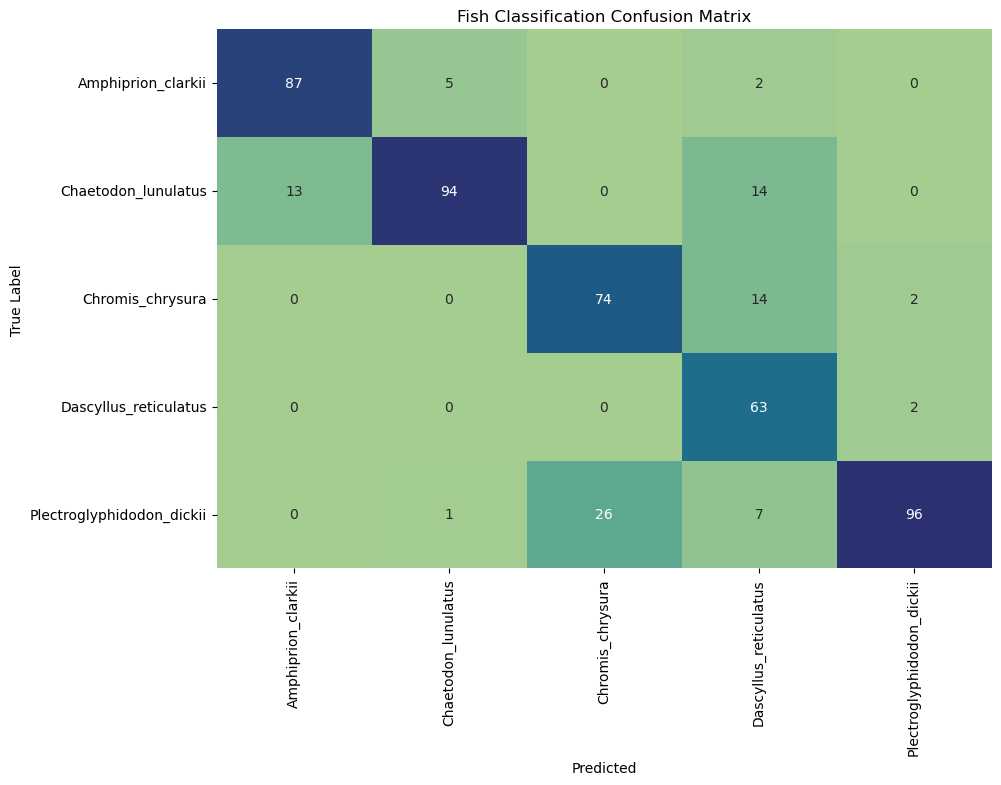

In [5]:
#Show confusion matrix
print(np.shape(gt))
print(np.shape(results))
create_conf(df,gt,results)

In [6]:
#Only FCN
skf = StratifiedKFold(n_splits=2, shuffle = True, random_state = 123)

X=dev_df.imP
y=dev_df.label
y=y.astype('int') 


gt = [] #ground truth (appended on each fold)
results = [] # validation results (appended on each fold)


#stratified split
for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    
    X_train_im = np.array(path2im(X_train))
    X_test_im = np.array(path2im(X_test))
    
    y_train = process_labels(y_train)
    y_test = process_labels(y_test)
    
    
    train_generator = DataGenerator(X_train_im, y_train, batch_size = 10)
    val_generator = DataGenerator(X_test_im, y_test, batch_size = 10)
    
    #create model
    model = tf.keras.models.Sequential()
    #add model layers
    model.add(tf.keras.Input(shape=(64,64,3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    
    #set optimiser
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_generator ,verbose=1, epochs=5, validation_data = val_generator)
    
    
    y_pred = model.predict(X_test_im)
    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1) #convert back from one-hot
    #add to arrays for confusion matrix
    gt = np.append(gt , y_test)
    results = np.append(results , y_pred)
    
    #get confusion matrix by adding actual and predicted on each run

0it [00:00, ?it/s]

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 1.9105 - accuracy: 0.3400 - val_loss: 1.1183 - val_accuracy: 0.6480
Epoch 2/5
25/25 [==============================] - 0s 4ms/step - loss: 0.3994 - accuracy: 0.8920 - val_loss: 1.3671 - val_accuracy: 0.5440
Epoch 3/5
25/25 [==============================] - 0s 4ms/step - loss: 0.1055 - accuracy: 0.9880 - val_loss: 1.0142 - val_accuracy: 0.6560
Epoch 4/5
25/25 [==============================] - 0s 5ms/step - loss: 0.0463 - accuracy: 1.0000 - val_loss: 0.8784 - val_accuracy: 0.7560
Epoch 5/5
8/8 [==============================] - 0s 2ms/step


1it [00:01,  1.85s/it]

Epoch 1/5
25/25 [==============================] - 0s 8ms/step - loss: 1.5497 - accuracy: 0.4080 - val_loss: 1.1083 - val_accuracy: 0.6200
Epoch 2/5
25/25 [==============================] - 0s 5ms/step - loss: 0.3771 - accuracy: 0.8880 - val_loss: 1.0730 - val_accuracy: 0.6280
Epoch 3/5
25/25 [==============================] - 0s 5ms/step - loss: 0.1297 - accuracy: 0.9800 - val_loss: 0.9469 - val_accuracy: 0.7160
Epoch 4/5
25/25 [==============================] - 0s 5ms/step - loss: 0.0544 - accuracy: 1.0000 - val_loss: 0.7387 - val_accuracy: 0.8280
Epoch 5/5
8/8 [==============================] - 0s 2ms/step


2it [00:03,  1.86s/it]


Accuracy: 0.83
Average Precision: 0.8548199621407481
Average Recall/Sensitivity: 0.8299999999999998
Average Specificity: 0.9574999999999999
Average F1 Score 0.8146820315280825
Average Cohen K 0.7753880174896564


<Figure size 2000x2000 with 0 Axes>

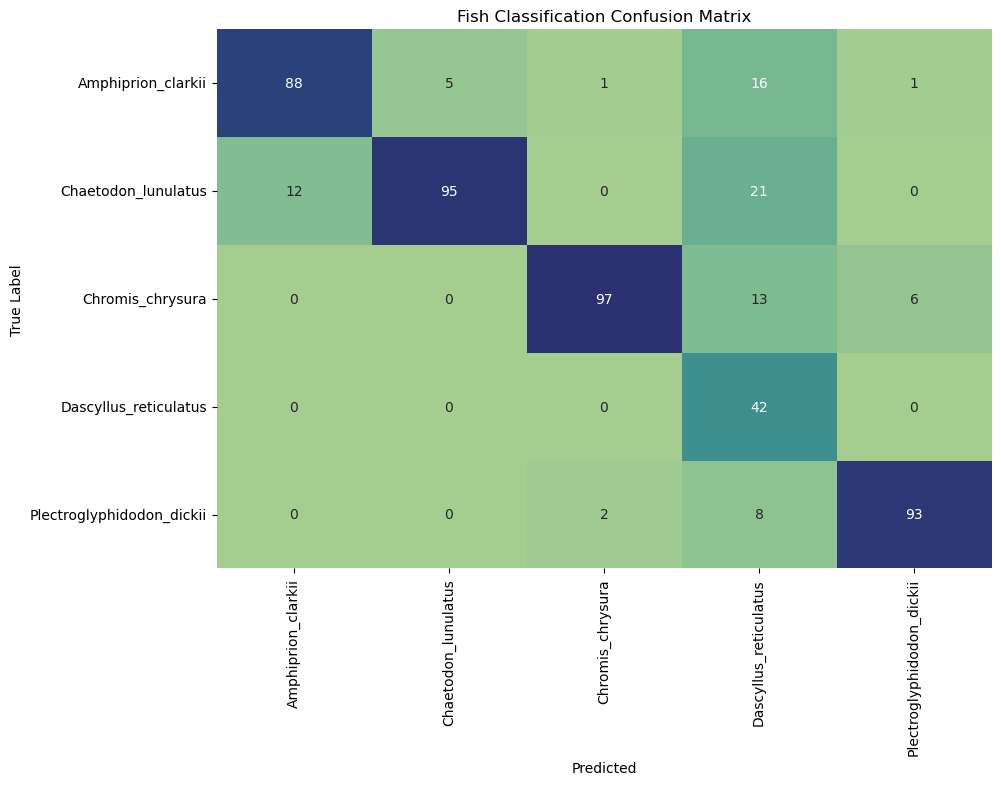

In [7]:
#get per class confusion matrix and calculate metrics
get_metrics(gt,results)
#Show confusion matrix
create_conf(df,gt,results)

In [8]:
#Convolutional Neural Network & FCN
skf = StratifiedKFold(n_splits=2, shuffle = True, random_state = 123)

X=dev_df.imP
y=dev_df.label
y=y.astype('int') 


gt = [] #ground truth (appended on each fold)
results = [] # validation results (appended on each fold)


#stratified split
for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    
    X_train_im = np.array(path2im(X_train))
    X_test_im = np.array(path2im(X_test))
    
    y_train = process_labels(y_train)
    y_test = process_labels(y_test)
    
    
    train_generator = DataGenerator(X_train_im, y_train, batch_size = 10)
    val_generator = DataGenerator(X_test_im, y_test, batch_size = 10)
    
    #create model
    model = tf.keras.models.Sequential()
    #add model layers
    model.add(tf.keras.Input(shape=(64,64,3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    
    #set optimiser
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_generator ,verbose=1, epochs=5, validation_data = val_generator)
    
    
    y_pred = model.predict(X_test_im)
    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1) #convert back from one-hot
    #add to arrays for confusion matrix
    gt = np.append(gt , y_test)
    results = np.append(results , y_pred)
    
    #get confusion matrix by adding actual and predicted on each run

0it [00:00, ?it/s]

Epoch 1/5
25/25 [==============================] - 1s 12ms/step - loss: 1.7029 - accuracy: 0.3440 - val_loss: 1.5130 - val_accuracy: 0.3480
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - loss: 1.0337 - accuracy: 0.6280 - val_loss: 1.2710 - val_accuracy: 0.5880
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 0.6226 - accuracy: 0.8000 - val_loss: 1.1317 - val_accuracy: 0.6720
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 0.3152 - accuracy: 0.9320 - val_loss: 0.8654 - val_accuracy: 0.7720
Epoch 5/5
8/8 [==============================] - 0s 2ms/step


1it [00:02,  2.41s/it]

Epoch 1/5
25/25 [==============================] - 1s 12ms/step - loss: 1.8709 - accuracy: 0.2080 - val_loss: 1.5059 - val_accuracy: 0.3600
Epoch 2/5
25/25 [==============================] - 0s 8ms/step - loss: 1.0651 - accuracy: 0.6320 - val_loss: 1.1020 - val_accuracy: 0.6840
Epoch 3/5
25/25 [==============================] - 0s 8ms/step - loss: 0.5457 - accuracy: 0.8720 - val_loss: 0.8147 - val_accuracy: 0.8120
Epoch 4/5
25/25 [==============================] - 0s 8ms/step - loss: 0.2255 - accuracy: 0.9480 - val_loss: 0.7315 - val_accuracy: 0.7520
Epoch 5/5
8/8 [==============================] - 0s 2ms/step


2it [00:04,  2.45s/it]


Accuracy: 0.868
Average Precision: 0.8848520708720103
Average Recall/Sensitivity: 0.868
Average Specificity: 0.967
Average F1 Score 0.8657529178320843
Average Cohen K 0.8333900621238511


<Figure size 2000x2000 with 0 Axes>

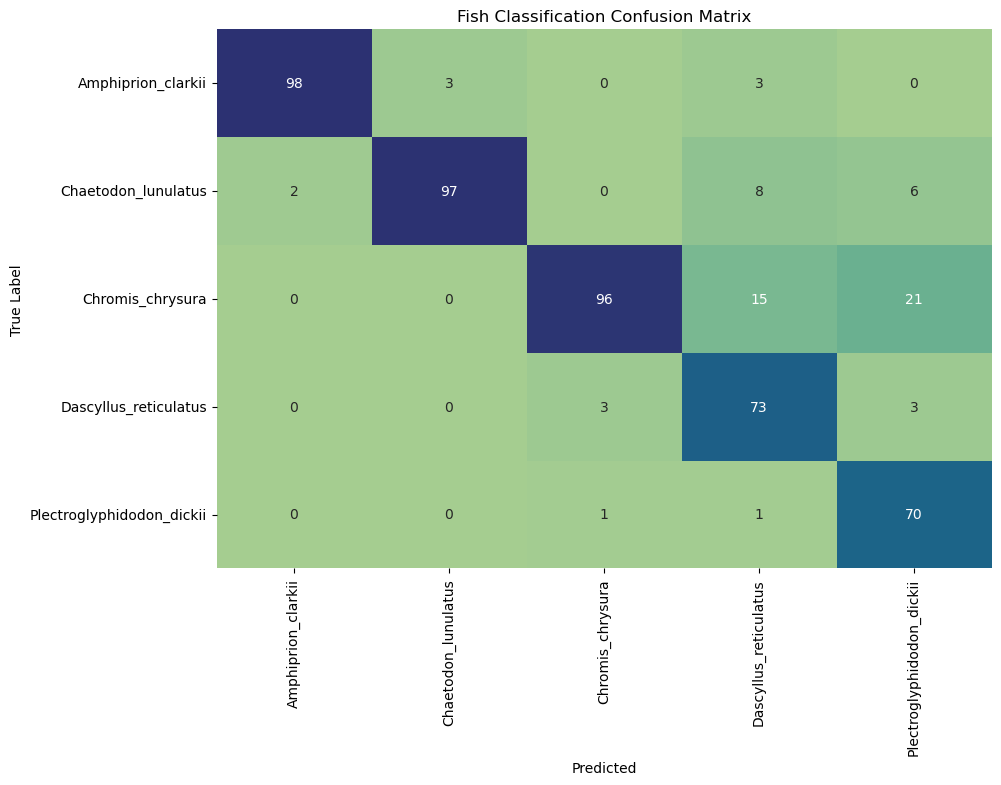

In [9]:
#get per class confusion matrix and calculate metrics
get_metrics(gt,results)
#Show confusion matrix
create_conf(df,gt,results)